<a href="https://colab.research.google.com/github/BiancaRAF/MNIST/blob/main/training_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST

O objetivo é reproduzir o projeto apresentado no curso da DIO.

O projeto tem como objetivo identificar números através de imagens.

Link relacionado: http://yann.lecun.com/exdb/mnist/

In [37]:
#Importação das biblotecas
import numpy as np
import torch #Framework - aliado do Tensorflow, outro framework
import torch.nn.functional as nf #Funções para a rede
import torchvision #Para visão computacional
import matplotlib.pyplot as plt
from time import time #Trabalhar com tempo no algortitmo (tempo execução, de rede etc)
from torchvision import datasets, transforms
from torch import nn, optim

Iremos baixar o dataset do MNIST e tranformar o dataset para o tipo de arquivo tensor.

O dataset é baixado do Yann Lecun, responsável pela parte de inteligência artifical e metaverso do Facebook.

A imagem em tensor possui uma representação relacionada numérica que a representa de uma forma mais apropriada para trabalhar com redes de deep learning que rodam no TensorFlow estão mais habituadas a trabalhar e, por isso, se torna mais eficiente. 

Ler mais sobre tensor: https://cursos.alura.com.br/forum/topico-transformar-imagem-em-um-tensor-179620


In [38]:
transform = transforms.ToTensor() #Definindo a conversão de imagens para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #Carrega a parte de validação do dataset
trainloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) #Cria um buffer para pegar os dados por partes

Verificar se a imagem está sendo corretamente chamada, no caso verificaremos apenas uma imagem.

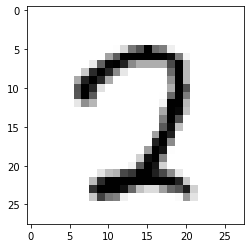

In [39]:
dataiter = iter(trainloader) #Função inter() ler uma imagem do dataset
imagens, etiquetas = dataiter.next() #Chamar o conjunto de imagens

plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

Verificar as dimensões do tensor da imagem e da etiqueta.

In [40]:
print(imagens[0].shape) #Relação da imagem com o tensor que a representa
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


Vamos começar a rede!

O modelo usado será o modelo Inception V3, também usado pelo Facebook para o reconhecimento facial.

Para usar o modelo não precisamos programar ele do zero, pois o encontramos pronto no site https://keras.io/api/applications/.

Há vários modelos já existentes, alguns desses modelos podem ser encontrados no site informado acima.

In [41]:
#Montando a estrutura da rede

class Modelo(nn.Module):
  
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) #Camada de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64)#Camada interna 1, 128 neurônios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) #Camada interna 2, 64 neurônios que se ligam a 10
    #Para a camada de saída não é necessário definir nada, pois só precisamos pegar o output da camada interna 2
  
  def foward(self, X):
    X = nf.relu(self.linear1(X)) #Função de ativação da camada de entrada para a camada interna 1
    X = nf.relu(self.linear2(X)) #Função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X) #Função de ativação de camada interna 2 para a camada de saída, nesse caso f(x) = X - ativa as camadas internas da rede
    return nf.log_softmax(X, dim=1) #Dados utilizados para calcular a perda 

### Otimização da rede:

Atualização de peso da rede - para isso, precisamos de um otimizador.

O otimizador é quem efetivamente treina a rede.

Observação: o ideal para o treinamento, é no mínimo 100 épocas. No exemplo usamos apenas 10 para ser mais rápido o desenvolvimento do mesmo.

In [42]:
#Estrutura de treinamento

def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #Define a política de atualização dos pesos e da bias
  inicio = time() #Timer para sabermos quanto tempo levou o treino

  criterio = nn.NLLLoss() #Definindo o critério para calcular a perda
  EPOCHS = 10 #Número de epochs que o algoritmo rodará
  modelo.train() #Ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 #Inicializando a perda acumulada da epoch em questão

    for imagens, etiquetas in trainloader:
      
      imagens = imagens.view(imagens.shape[0], -1) #Convertendo as imagens em "vetores" de 28*28 casas para ficarem compatíveis com a 
      otimizador.zero_grad() #Zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) #Colocando os dados do modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) #Calculando a perda da epoch em questão

      perda_instantanea.backward() #Back propagation a partir da perda

      otimizador().step() #Atualizando os pesos e bias

      perda_acumulada += perda_instantanea.item() #Atualização da perda acumulada
    
    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) = ", (time()-inicio)/60)

Agora, criar o modelo de validação.

In [43]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784) # 784, pois 28*28
      #Desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos têm um custo alto de processamento
      with torch.nograd():
        logps = modelo(img.to(device)) #Output do modelo em escala logaritmica
    
    ps = torch.exp(logps) #Converte output para escala normal (lembrando que é um tensor)
    probab = list(ps.cpu().numpy()[0])
    etiqueta_pred = probab.index(max(probab)) #Converte o tensor em um número, no caso, o número que o modelo previu ---
    etiqueta_certa = etiquetas.numpy()[i]

    if (etiqueta_certa == etiqueta_pred):
      conta_corretas += 1
    conta_todas += 1
  print("Total de imagens testadas = ", conta_todas)
  print(f"\nPrecisão do modelo = {conta_corretas*100/conta_todas}%")

Vamos fazer a leitura do modelo que rodará na rede.

In [44]:
modelo = Modelo() #Chamando o Modelo para executar - inicializa do modelo de treinamento

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Modelo rodará na GPU se possível - verifica se é possível roda no cuda, se tiver uma nvideo dará, se não será no CPU
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)